In [ ]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from torch import nn
from torch.optim import Adam
from utils.utils import rmse_error
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from datasets.lorenz import LorenzDataset
from utils.plotting import plot_lorenz_predictions

device = 'cuda'

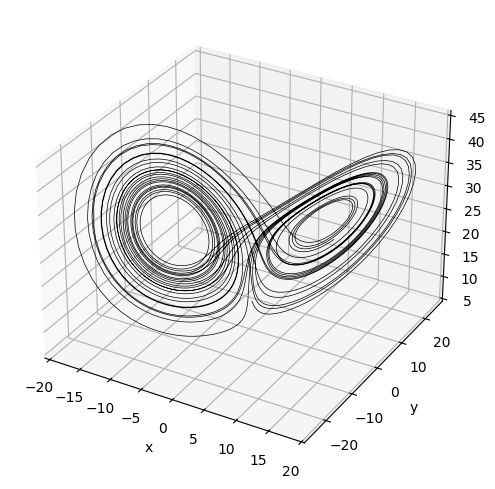

In [60]:
x0 = np.array([0,1,10])
dataset_lorenz = LorenzDataset(x0=x0, t_span=(0,30), dt=0.01, mode='full', device=device)
x_lorenz = dataset_lorenz.series

ax = plt.figure(figsize=(6,6)).add_subplot(projection='3d')
ax.plot(*x_lorenz.T.cpu(), lw=0.5, color='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

### 1 - Traditional reservoir computing

Fit RMSE = 0.016
Forecast RMSE = 18.952


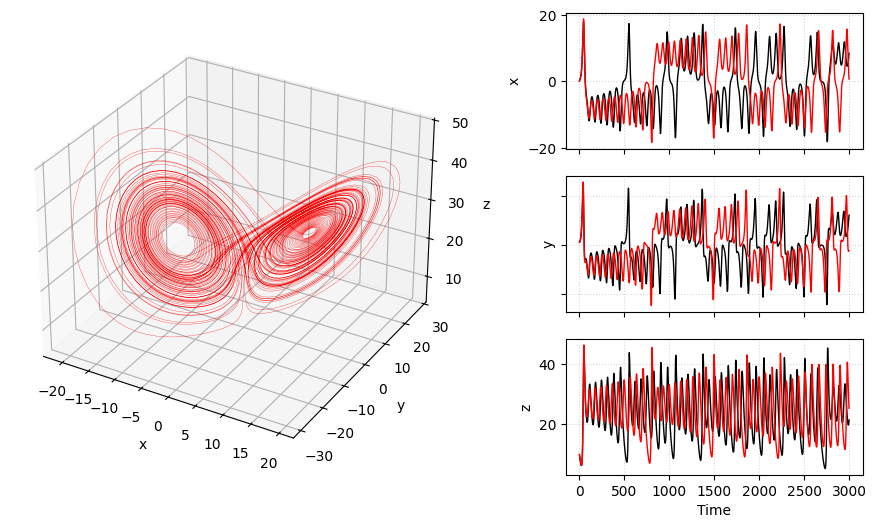

In [68]:
from models.reservoir import ReservoirModel

# Strong dependence on the hyperparameters. Many combinations give really bad results
model = ReservoirModel(features_dim=3,
                       N_nodes=200, connectivity_density=0.2,
                       spectral_radius=0.1, alpha_regularizer=1e-5,
                       input_weight_strength=0.03,
                       predict_mode='next').to(device)

loss = model.fit(x_lorenz)
print(f'Fit RMSE = {loss:.3f}')

x_pred = model.generate(x_init=x_lorenz[0,:], num_steps=10000)
plot_lorenz_predictions(x_pred, x_true=x_lorenz[1:,:])

prediction_error = rmse_error(x_lorenz[1:,:], x_pred)
print(f'Forecast RMSE = {prediction_error:.3f}') 


### 2 - Polynomial Embeddings

Fit RMSE = 0.002
Forecast RMSE = 20.404


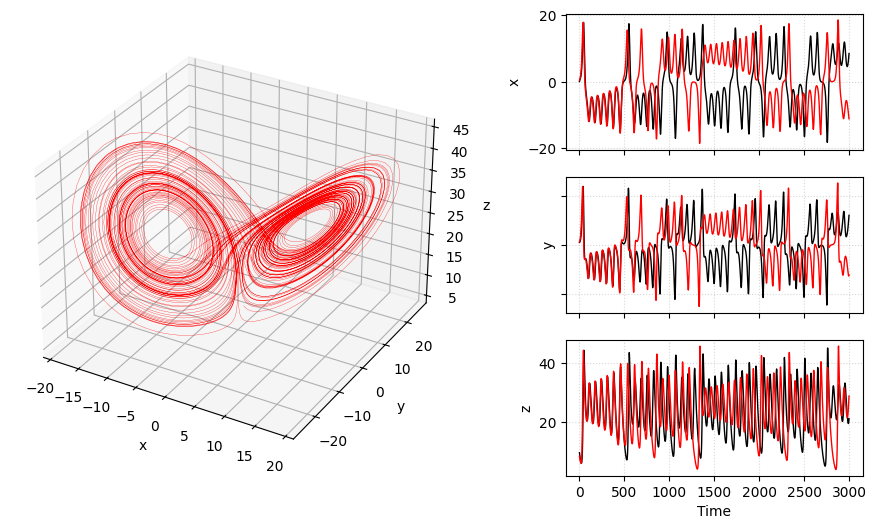

In [69]:
from models.polynomial_embedding import PolynomialEmbeddingModel

model = PolynomialEmbeddingModel(features_dim=3,
                                 k_steps=3, skip=1,
                                 alpha_regularizer=1e-3,
                                 predict_mode='next').to(device)

loss = model.fit(x_lorenz)
print(f'Fit RMSE = {loss:.3f}')

x_pred = model.generate(x_init=x_lorenz[0:6,:], num_steps=10000)
plot_lorenz_predictions(x_pred, x_true=x_lorenz[1:,:])

prediction_error = rmse_error(x_lorenz[1:,:], x_pred)
print(f'Forecast RMSE = {prediction_error:.3f}') 


### 3 - Recurrent model

100%|██████████| 5000/5000 [00:33<00:00, 147.91it/s, loss=0.0976]


Forecast RMSE = 16.077


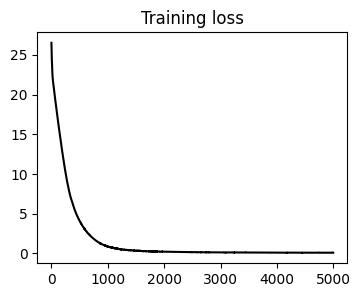

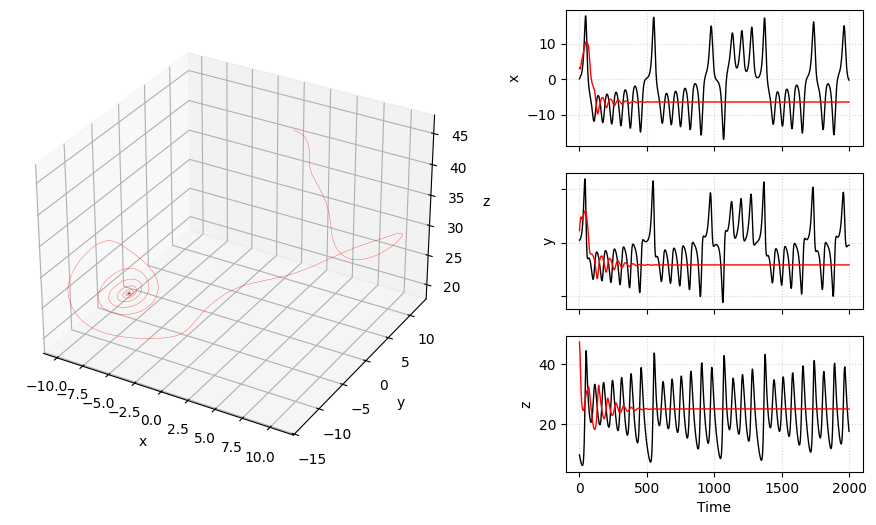

In [103]:
from models.recurrent import RecurrentModel

model = RecurrentModel(features_dim=3,
                       hidden_dim=64,
                       recurrent_layers=1,
                       predict_mode='next').to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

loss_history = model.fit(x_lorenz, optimizer=optimizer, epochs=5000)
plt.figure(figsize=(4,3))
plt.plot(loss_history, 'k')
plt.title('Training loss')

x_pred = model.generate(x_init=x_lorenz[0,:], num_steps=2000)
plot_lorenz_predictions(x_pred, x_true=x_lorenz[1:,:])

prediction_error = rmse_error(x_lorenz[1:,:], x_pred)
print(f'Forecast RMSE = {prediction_error:.3f}') 


100%|██████████| 5000/5000 [01:10<00:00, 70.94it/s, loss=0.0242]


Forecast RMSE = 18.388


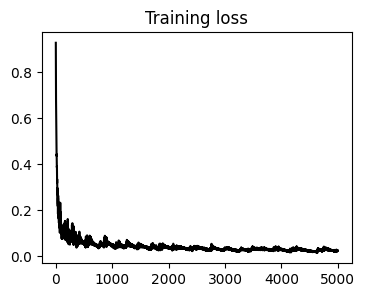

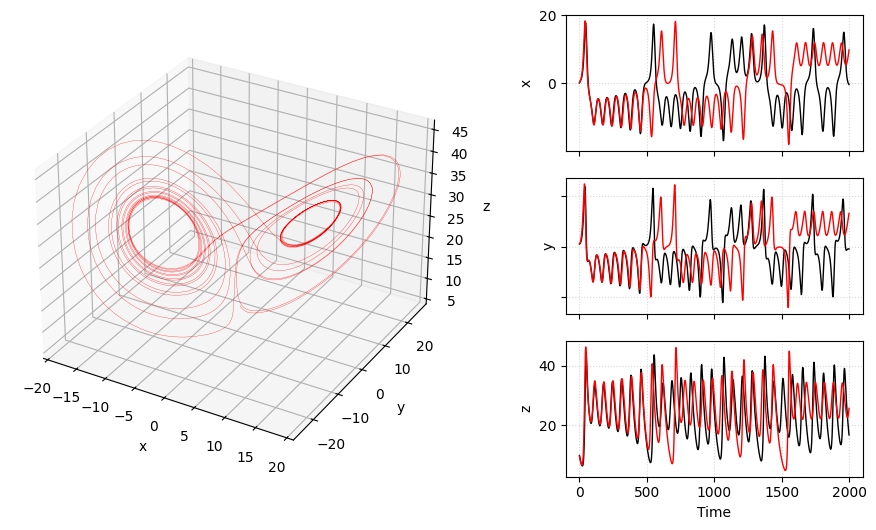

In [104]:
# Only way to make it work: increase the number of recurrent layers and predict the derivative
model = RecurrentModel(features_dim=3,
                       hidden_dim=64,
                       recurrent_layers=4,
                       predict_mode='residual').to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

loss_history = model.fit(x_lorenz, optimizer=optimizer, epochs=5000)
plt.figure(figsize=(4,3))
plt.plot(loss_history, 'k')
plt.title('Training loss')

x_pred = model.generate(x_init=x_lorenz[0:2,:], num_steps=2000)
plot_lorenz_predictions(x_pred, x_true=x_lorenz[1:,:])

prediction_error = rmse_error(x_lorenz[1:,:], x_pred)
print(f'Forecast RMSE = {prediction_error:.3f}') 


  0%|          | 24/5000 [00:00<00:42, 115.84it/s, loss=0.431]

100%|██████████| 5000/5000 [00:39<00:00, 125.01it/s, loss=0.0141] 


Forecast RMSE = 18.326


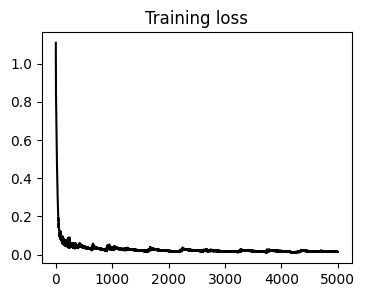

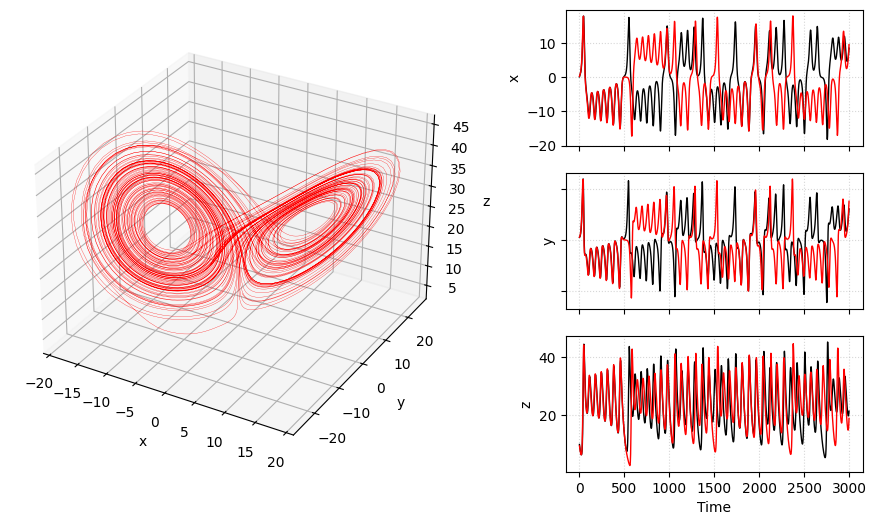

In [ ]:
# Use a custom architecture (non-linear encoder/decoder + LSTM network)
encoder_model = nn.Sequential(nn.Linear(3, 32), 
                              nn.SELU(),
                              nn.Linear(32, 64))

decoder_model = nn.Sequential(nn.Linear(64, 32), 
                              nn.SELU(),
                              nn.Linear(32, 3))

recurrent_model = nn.LSTM(input_size=64, hidden_size=64, num_layers=1)

model = RecurrentModel(features_dim=3,
                       encoder_model=encoder_model,
                       decoder_model=decoder_model,
                       recurrent_model=recurrent_model,
                       predict_mode='residual').to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
loss_history = model.fit(x_lorenz, optimizer=optimizer, epochs=5000)
plt.figure(figsize=(4,3))
plt.plot(loss_history, 'k')
plt.title('Training loss')

x_pred = model.generate(x_init=x_lorenz[0,:], num_steps=5000)
plot_lorenz_predictions(x_pred, x_true=x_lorenz[1:,:])

prediction_error = rmse_error(x_lorenz[1:,:], x_pred)
print(f'Forecast RMSE = {prediction_error:.3f}') 


### 4 - Neural Autoregressive model

In [143]:
x0 = np.array([0,1,10])
dataset_lorenz = LorenzDataset(x0=x0, t_span=(0,30), dt=0.01, mode='window',
                               window_length=40, window_shift=5,
                               device=device)


dataloader = DataLoader(dataset_lorenz, batch_size=64, shuffle=True)

100%|██████████| 500/500 [03:53<00:00,  2.15it/s, Loss=1.1476e-01]


Forecast RMSE = 18.330


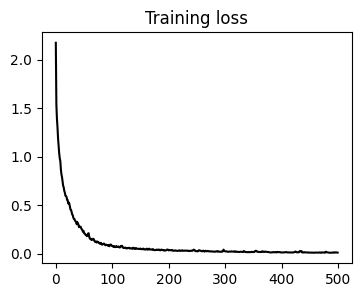

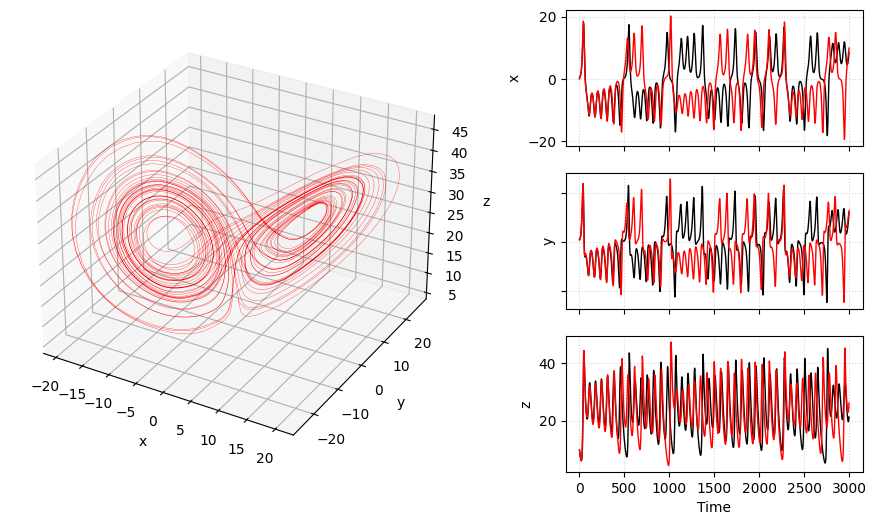

In [146]:
from models.autoregressive_neural import NeuralAutoregressiveResidual

model = NeuralAutoregressiveResidual(features_dim=3, sigma=1e-2).to(device)
optimizer = Adam(model.parameters(), lr=3e-4)

loss_history = model.fit(dataloader, optimizer, epochs=500)

plt.figure(figsize=(4,3))
plt.plot(loss_history, 'k')
plt.title('Training loss')

x_pred = model.generate(x_init=x_lorenz[0,:], num_steps=5000)
plot_lorenz_predictions(x_pred, x_true=x_lorenz[1:,:])

prediction_error = rmse_error(x_lorenz[1:,:], x_pred)
print(f'Forecast RMSE = {prediction_error:.3f}') 